#Proyecto final APPSA

Author:  Enrique Ernesto de Alvear Doñate

***Hybrid Demucs***

(https://github.com/facebookresearch/demucs/)

***Whisper model***

(https://github.com/openai/whisper)

In [ ]:
#Descargar el Demucs para la separación de características de audio
!python3 -m pip install -U git+https://github.com/facebookresearch/demucs#egg=demucs

  Cloning https://github.com/facebookresearch/demucs to /tmp/pip-install-nhvupg79/demucs_82c99ddb152748638e87689e65369390
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/demucs /tmp/pip-install-nhvupg79/demucs_82c99ddb152748638e87689e65369390
  Resolved https://github.com/facebookresearch/demucs to commit e976d93ecc3865e5757426930257e200846a520a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.1/87.1 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.8/239.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 5.0 MB/s et

In [2]:
#librerías y paquetes para Whisper
!pip install -U openai-whisper
!pip install --upgrade --no-deps --force-reinstall git+https://github.com/openai/whisper.git
!sudo apt update && sudo apt install ffmpeg

!pip install setuptools-rust

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 61.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using ca

In [3]:
#librería para evaluación WER
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.6 MB/s eta 0:00:00


In [4]:
# Please BE VERY CAREFUL, this will link your entire drive.
# So don't edit code, except the one that says 'Customize the following options',
# or you might mess up your files.
# IF YOU DO NO WANT TO LINK DRIVE, please see below for an alternative!
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!cd /gdrive/MyDrive/APPSA_tf

In [5]:
# Customize the following options!
model = "htdemucs"
extensions = ["mp3", "wav", "ogg", "flac"]  # we will look for all those file types.
two_stems = None   # only separate one stems from the rest, for instance
#two_stems = "vocals"

# Options for the output audio.
mp3 = True
mp3_rate = 320
float32 = False  # output as float 32 wavs, unsused if 'mp3' is True.
int24 = False    # output as int24 wavs, unused if 'mp3' is True.
# You cannot set both `float32 = True` and `int24 = True` !!

initial_root_in = '/gdrive/MyDrive/APPSA_tf/Canciones/'
initial_root_out = '/gdrive/MyDrive/APPSA_tf/Salidas_canciones/'
root_lyrics = '/gdrive/MyDrive/APPSA_tf/Lyrics_reales/'
write_path = '/gdrive/MyDrive/APPSA_tf/Salida_lyrics/'
in_path = initial_root_in
out_path = initial_root_out

In [6]:
#@title Useful functions, don't forget to execute
import io
from pathlib import Path
import select
from shutil import rmtree
import subprocess as sp
import sys
from typing import Dict, Tuple, Optional, IO

from google.colab import files

def find_files(in_path):
    out = []
    for file in Path(in_path).iterdir():
        if file.suffix.lower().lstrip(".") in extensions:
            out.append(file)
    return out

def copy_process_streams(process: sp.Popen):
    def raw(stream: Optional[IO[bytes]]) -> IO[bytes]:
        assert stream is not None
        if isinstance(stream, io.BufferedIOBase):
            stream = stream.raw
        return stream

    p_stdout, p_stderr = raw(process.stdout), raw(process.stderr)
    stream_by_fd: Dict[int, Tuple[IO[bytes], io.StringIO, IO[str]]] = {
        p_stdout.fileno(): (p_stdout, sys.stdout),
        p_stderr.fileno(): (p_stderr, sys.stderr),
    }
    fds = list(stream_by_fd.keys())

    while fds:
        # `select` syscall will wait until one of the file descriptors has content.
        ready, _, _ = select.select(fds, [], [])
        for fd in ready:
            p_stream, std = stream_by_fd[fd]
            raw_buf = p_stream.read(2 ** 16)
            if not raw_buf:
                fds.remove(fd)
                continue
            buf = raw_buf.decode()
            std.write(buf)
            std.flush()

def separate(inp=None, outp=None):
    inp = inp or in_path
    outp = outp or out_path
    cmd = ["python3", "-m", "demucs.separate", "-o", str(outp), "-n", model]
    if mp3:
        cmd += ["--mp3", f"--mp3-bitrate={mp3_rate}"]
    if float32:
        cmd += ["--float32"]
    if int24:
        cmd += ["--int24"]
    if two_stems is not None:
        cmd += [f"--two-stems={two_stems}"]
    files = [str(f) for f in find_files(inp)]

    if not files:
        print(f"No valid audio files in {in_path}")
        return
    print("Going to separate the files:")
    print('\n'.join(files))
    print("With command: ", " ".join(cmd))
    p = sp.Popen(cmd + files, stdout=sp.PIPE, stderr=sp.PIPE)
    copy_process_streams(p)
    p.wait()
    if p.returncode != 0:
        print("Command failed, something went wrong.")


def from_upload():
    out_path = Path('separated')
    in_path = Path('tmp_in')

    if in_path.exists():
        rmtree(in_path)
    in_path.mkdir()

    if out_path.exists():
        rmtree(out_path)
    out_path.mkdir()

    uploaded = files.upload()
    for name, content in uploaded.items():
        (in_path / name).write_bytes(content)
    separate(in_path, out_path)


In [ ]:
# This can be quite slow, in particular the loading, and saving from GDrive. Please be patient!
# This is from google drive! Also, this will separate all the files inside the MyDrive/demucs folder,
# so when you are happy with the results, remove the songs from there.
# in_path = initial_root_in+"prueba/"
# out_path = initial_root_out + "salida_prueba/"
# separate(inp = in_path, outp = out_path)

In [ ]:
# This is manual upload and download :)
# from_upload()
# !zip -r separated.zip separated
# files.download('./separated.zip')

Ahora hago una prueba de reconocimiento de texto

In [ ]:
# import whisper

# model_transcrip = whisper.load_model("large-v3")

# result = model_transcrip.transcribe(out_path + "htdemucs/Lemon Tree - Fools Garden/vocals.mp3")
# print(result["text"])

In [ ]:


# load audio and pad/trim it to fit 30 seconds
# audio = whisper.load_audio(out_path + "htdemucs/Lemon Tree - Fools Garden/vocals.mp3")
# audio = whisper.pad_or_trim(audio)

# # make log-Mel spectrogram and move to the same device as the model
# mel = whisper.log_mel_spectrogram(audio).to(model.device)

# # detect the spoken language
# _, probs = model.detect_language(mel)
# print(f"Detected language: {max(probs, key=probs.get)}")

# # decode the audio
# options = whisper.DecodingOptions()
# result = whisper.decode(model, mel, options)

# # print the recognized text
# print(result.text)

Para comparar los textos

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

def calcular_similitud(texto1, texto2):
    # Preprocesamiento de los textos
    stop_words = set(stopwords.words("spanish"))
    lemmatizer = WordNetLemmatizer()
    tokens1 = [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(texto1) if word.isalnum() and word.lower() not in stop_words]
    tokens2 = [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(texto2) if word.isalnum() and word.lower() not in stop_words]

    # Unión de los tokens preprocesados en textos nuevamente
    texto_preprocesado1 = ' '.join(tokens1)
    texto_preprocesado2 = ' '.join(tokens2)

    # Creación del vectorizador TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([texto_preprocesado1, texto_preprocesado2])

    # Cálculo de la similitud de coseno entre los vectores TF-IDF
    similitud = (tfidf_matrix * tfidf_matrix.T).toarray()[0, 1]

    return similitud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# salida = "I'm sitting here in the boring room. It's just another rainy Sunday afternoon. I'm wasting my time. I got nothing to do. I'm hanging aroundI'm waiting for you But nothing ever happens and I wonder I'm driving around in my car I'm driving too fast I'm driving too far. I'd like to change my point of view. I feel so lonely I'm waiting for you But nothing ever happens and I wonder. I wonder how I wonder why. Yesterday you told me 'bout the blue, blue sky And all that I can see is just a yellow lemon tree I'm turning my head up and down. I'm turning, turning, turning, turning, turning around. And all that I can see is just another lemon tree. Sing! I'm sitting here. I miss the power. I'd like to go out taking a shower. But there's a heavy cloud inside my head. I feel so tired. Put myself into bed. While nothing ever happens and I wonder. Isolation is not good for me. Isolation I don't want to sit on the lemon tree.I'm stepping around in the desert of joy. Baby, anyhow I'll get another toy. And everything will happen and you wonder. I wonder how. I wonder why. Yesterday you told me 'bout the blue, blue sky. And all that I can see is just another lemon tree. I'm turning my head up and down. I'm turning, turning, turning, turning, turning around. And all that I can see is just a yellow lemon tree. And I wonder, wonder. I wonder how. I wonder why. Yesterday you told me 'bout the blue, blue sky. And all that I can see, and all that I can see, and all that I can see. Is just a yellow lemon tree"
# calcular_similitud(result["text"], salida)

In [ ]:
# import jiwer


# transforms = jiwer.Compose(
#     [
#         jiwer.ExpandCommonEnglishContractions(),
#         jiwer.RemoveEmptyStrings(),
#         jiwer.ToLowerCase(),
#         jiwer.RemoveMultipleSpaces(),
#         jiwer.Strip(),
#         jiwer.RemovePunctuation(),
#         jiwer.ReduceToListOfListOfWords(),
#     ]
# )

In [ ]:
# wer = jiwer.wer(
#                 salida,
#                 result["text"],
#                 truth_transform=transforms,
#                 hypothesis_transform=transforms,
#             )
# print(f"Word Error Rate (WER) :", wer)

Ahora que hemos hecho la prueba con un audio vamos a intentar hacer la prueba con todos

In [8]:
import os
import pandas as pd
import numpy as np

import jiwer

def buscar_lyrics(song, genre):
  lyrics = ''
  try:
    with open(root_lyrics+genre+"/"+song+'.txt', "r") as text:
      for line in text.readlines():
        lyrics += line.replace("\n", " ")
  except:
    print(f"La canción {song} no se encuentra entre los lyrics")
  return lyrics

genres = ["pop", "rock", "metal"]


def separate_eval(inp=None, outp=None):
    inp = inp or in_path
    outp = outp or out_path
    cmd = ["python3", "-m", "demucs.separate", "-o", str(outp), "-n", model]
    if mp3:
        cmd += ["--mp3", f"--mp3-bitrate={mp3_rate}"]
    if float32:
        cmd += ["--float32"]
    if int24:
        cmd += ["--int24"]
    if two_stems is not None:
        cmd += [f"--two-stems={two_stems}"]
    files = [str(f) for f in find_files(inp)]
    if not files:
        print(f"No valid audio files in {in_path}")
        return
    print("Going to separate the files:")
    print('\n'.join(files))
    print("With command: ", " ".join(cmd))
    p = sp.Popen(cmd + files, stdout=sp.PIPE, stderr=sp.PIPE)
    copy_process_streams(p)
    p.wait()
    if p.returncode != 0:
        print("Command failed, something went wrong.")
    return files

def evaluar_modelo(genre, model):
  in_path = initial_root_in + genre + "/"
  out_path = initial_root_out + genre + "/"

  files_names = separate_eval(in_path, out_path)
  files_names = [str(item).split("/")[-1].replace(".mp3","") for item in files_names]

  i = 0
  df = pd.DataFrame(columns = ("song_name", "WER", "Tf_idf"))

  transforms = jiwer.Compose(
    [
        jiwer.ExpandCommonEnglishContractions(),
        jiwer.RemoveEmptyStrings(),
        jiwer.ToLowerCase(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.Strip(),
        jiwer.RemovePunctuation(),
        jiwer.ReduceToListOfListOfWords(),
    ])

  for file in files_names:
    result = model.transcribe(out_path + "htdemucs/"+file+"/vocals.mp3")
    real_out = buscar_lyrics(file, genre)
    with open(write_path + genre + "/"+ file +".txt", "w") as f:
      f.write(result["text"])

    if real_out:
      wer = jiwer.wer(
                  real_out,
                  result["text"],
                  truth_transform=transforms,
                  hypothesis_transform=transforms,
              )

      cer = jiwer.cer(
                  real_out,
                  result["text"],
                  truth_transform=transforms,
                  hypothesis_transform=transforms,
              )

      mer = jiwer.mer(
                  real_out,
                  result["text"],
                  truth_transform=transforms,
                  hypothesis_transform=transforms,
              )

      tfidf = calcular_similitud(real_out, result["text"])

      df.loc[i] = [file, wer, tfidf]
      i+=1
    else:
      print(f"File {file} skipped ")
  return df


In [15]:
def evaluar_modelopt1(genre, model):
  in_path = initial_root_in + genre + "/"
  out_path = initial_root_out + genre + "/"
  files_names = separate_eval(in_path, out_path)
  files_names = [str(item).split("/")[-1].replace(".mp3","") for item in files_names]
  return files_names

def evaluar_modelopt2(genre, model, files_names):
  i = 0
  df = pd.DataFrame(columns = ("song_name", "WER", "Tf_idf", "CER", "MER"))
  in_path = initial_root_in + genre + "/"
  out_path = initial_root_out + genre + "/"
  transforms = jiwer.Compose(
    [
        jiwer.ExpandCommonEnglishContractions(),
        jiwer.RemoveEmptyStrings(),
        jiwer.ToLowerCase(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.Strip(),
        jiwer.RemovePunctuation(),
        jiwer.ReduceToListOfListOfWords(),
    ])
  for file in files_names:
    print(file)
    result = model.transcribe(out_path + "htdemucs/"+file+"/vocals.mp3")
    real_out = buscar_lyrics(file, genre)
    with open(write_path + genre + "/"+ file +".txt", "w") as f:
      f.write(result["text"])
    if real_out:
      wer = jiwer.wer(
                  real_out,
                  result["text"],
                  truth_transform=transforms,
                  hypothesis_transform=transforms,
              )
      cer = jiwer.cer(
                  real_out,
                  result["text"],
                  truth_transform=transforms,
                  hypothesis_transform=transforms,
              )
      mer = jiwer.mer(
                  real_out,
                  result["text"],
                  truth_transform=transforms,
                  hypothesis_transform=transforms,
              )
      tfidf = calcular_similitud(real_out, result["text"])
      df.loc[i] = [file, wer, tfidf, cer, mer]
      i+=1
    else:
      print(f"File {file} skipped ")
  return df


In [11]:
#Dibujar las gráficas
import matplotlib.pyplot as plt
def graficas_res(df):
  df.plot(x = "WER", y = "Tf_idf", kind = "scatter", title = "WER vs tf-idf", xlabel = "WER", ylabel = "tfidf", xlim = (0,1.5), ylim = (0,1))
  plt.plot()
  # df.plot(x = "WER", y = "CER", kind = "scatter", title = "WER vs CER", xlabel = "WER", ylabel = "CER", xlim = (0,1.5), ylim = (0,1.5))

  # df.plot(x = "WER", y = "MER", kind = "scatter", title = "WER vs MER", xlabel = "WER", ylabel = "MER", xlim = (0,1.5), ylim = (0,1.5))

  print(f"Media métricas:\n", df[["WER", "Tf_idf", "CER", "MER"]].mean() )
  print("\n___________________________________________________\n\n")

In [ ]:
#Procesamiento para el género pop
import whisper

model_transcrip = whisper.load_model("large-v3")

#Descomentar estas dos lineas si no se tienen separados los audios
# files_names_pop = evaluar_modelopt1("pop", model)
# print("Fin de la separación de los audios")

#comentar esta linea si se descomentan las anteriores
files_names_pop = [str(f).split("/")[-1].replace(".mp3","") for f in find_files(initial_root_in + "pop" + "/")]

df_pop = evaluar_modelopt2("pop", model_transcrip, files_names_pop)
print(df_pop.head())
df_pop.to_csv("/gdrive/MyDrive/APPSA_tf/df_pop.csv")

100%|█████████████████████████████████████| 2.88G/2.88G [00:31<00:00, 98.2MiB/s]


Dancing queen
Rick Astley - Never Gonna Give You Up
Frank Sinatra Fly Me To The Moon
Keane - Somewhere Only We Know
Keane - Can't Stop Now
Coldplay - 04 Fix you
Coldplay - 10 The hardest part
02-lukas_graham-lullaby-718cd295
Oasis - 5 - I'm Outta Time
05 - Skin and Bones
08 - Gorgeous
George Michael - One More Try
Lemon Tree - Fools Garden
Come a little bit closer , Jay Americans
father and son - cat stevens
George Michael - Careless Whisper
14 - Call It What You Want
Boney M - Rasputin
Hooked On A Feeling
Isnt She Lovely
                               song_name       WER    Tf_idf       CER  \
0                          Dancing queen  0.752294  0.910860  0.752294   
1  Rick Astley - Never Gonna Give You Up  0.244624  0.987383  0.244624   
2       Frank Sinatra Fly Me To The Moon  0.382353  0.921065  0.382353   
3         Keane - Somewhere Only We Know  0.095070  0.983981  0.095070   
4                 Keane - Can't Stop Now  0.476190  0.866602  0.476190   

        MER  
0  0.467236  

In [ ]:
df_pop

,song_name,WER,Tf_idf,CER,MER
0,Dancing queen,0.752294,0.910860,0.752294,0.467236
1,Rick Astley - Never Gonna Give You Up,0.244624,0.987383,0.244624,0.219277
2,Frank Sinatra Fly Me To The Moon,0.382353,0.921065,0.382353,0.280576
3,Keane - Somewhere Only We Know,0.095070,0.983981,0.095070,0.089404
4,Keane - Can't Stop Now,0.476190,0.866602,0.476190,0.348432
5,Coldplay - 04 Fix you,0.659341,0.912762,0.659341,0.433213
6,Coldplay - 10 The hardest part,0.382857,0.962460,0.382857,0.308756
7,02-lukas_graham-lullaby-718cd295,0.401554,0.845107,0.401554,0.331197
8,Oasis - 5 - I'm Outta Time,0.958140,0.210836,0.958140,0.958140
9,05 - Skin and Bones,0.139881,0.943244,0.139881,0.127027


In [ ]:
#Procesamiento para el género rock

#Descomentar estas dos líneas si no se ha ejecutado en celdas anteriores
#import whisper
#model_transcrip = whisper.load_model("large-v3")

#Descomentar estas lineas si no se tienen los audios separados
# files_names_rock = evaluar_modelopt1("rock", model)
# print("Fin de la separación de los audios")

#comentar esta linea si se descomentan las anteriores
files_names_rock = [str(f).split("/")[-1].replace(".mp3","") for f in find_files(initial_root_in + "rock" + "/")]

df_rock = evaluar_modelopt2("rock", model_transcrip, files_names_rock)
print(df_rock.head())
df_rock.to_csv("/gdrive/MyDrive/APPSA_tf/df_rock.csv")

Smooth Criminal
A kind of Magic
Bohemian Rhapsody
Dont Stop Me Now
Billie Jean
Guns N Roses - Sweet Child O Mine
Panic At The Disco - Emperors New Clothes
Foster The People - Pumped up Kicks
Imagine Dragons - Its Time
Imagine Dragons - Natural
07. Don t Tell
Jumpsuit
05 - The World is Ugly
12-my_chemical_romance-famous_last_words
Read my mind
Mr.-Blue-Sky
Lake-Shore-Drive
David Bowie - Starman
Billy Joel - Piano Man
Fiesta Pagana
Green Day - 21 Guns
           song_name       WER    Tf_idf       CER       MER
0    Smooth Criminal  0.969178  0.453787  0.969178  0.735065
1    A kind of Magic  0.574561  0.970123  0.574561  0.399390
2  Bohemian Rhapsody  0.409449  0.750629  0.409449  0.334047
3   Dont Stop Me Now  0.422222  0.796052  0.422222  0.386179
4        Billie Jean  0.985325  0.042597  0.985325  0.985325


In [ ]:
df_rock
#mostramos el df rock completo

,song_name,WER,Tf_idf,CER,MER
0,Smooth Criminal,0.969178,0.453787,0.969178,0.735065
1,A kind of Magic,0.574561,0.970123,0.574561,0.399390
2,Bohemian Rhapsody,0.409449,0.750629,0.409449,0.334047
3,Dont Stop Me Now,0.422222,0.796052,0.422222,0.386179
4,Billie Jean,0.985325,0.042597,0.985325,0.985325
5,Guns N Roses - Sweet Child O Mine,0.969231,0.159906,0.969231,0.969231
6,Panic At The Disco - Emperors New Clothes,0.790769,0.349156,0.790769,0.667532
7,Foster The People - Pumped up Kicks,0.977887,0.096646,0.977887,0.977887
8,Imagine Dragons - Its Time,0.238506,0.900931,0.238506,0.204433
9,Imagine Dragons - Natural,0.126471,0.944154,0.126471,0.121813


In [ ]:
#Procesamiento para el género metal

#Descomentar estas dos líneas si no se ha ejecutado en celdas anteriores
import whisper
model_transcrip = whisper.load_model("large-v3")

#Descomentar estas dos lineas si no se tienen separadas las canciones
#files_names_metal = evaluar_modelopt1("metal", model)
#print("Fin de la separación de los audios")

#comentar esta linea si se descomentan las anteriores
files_names_metal = [str(f).split("/")[-1].replace(".mp3","") for f in find_files(initial_root_in + "metal" + "/")]

df_metal = evaluar_modelopt2("metal", model_transcrip, files_names_metal)
print(df_metal.head())
df_metal.to_csv("/gdrive/MyDrive/APPSA_tf/df_metal.csv")

100%|██████████████████████████████████████| 2.88G/2.88G [00:30<00:00, 100MiB/s]


Slipknot - Psychosocial
Jekyll and Hide
White knuckles
Better days-hollow point heroes
Burn motherfucker
Avatar - A Statue Of The King
Dragonforce - Fury of the Storm
Circus sideshow-hollow point heroes
Avatar - The Eagle Has Landed
Avatar - Hail The Apocalypse
Cradle to the Grave
Sabaton_The_Lion_From_The_North
Powerwolf  - Resurrection By Erection
Stratovarius - Halcyon Days
Five Finger Death Punch - American Capitalist
Five Finger Death Punch - War Is the Answer
Of Mice and Men - Instincts
Let me hear
Wolf and raven-sonata arctica
Rhapsody - Emerald Sword  Epicus Furor
                         song_name       WER    Tf_idf       CER       MER
0          Slipknot - Psychosocial  0.990798  0.023514  0.990798  0.990798
1                  Jekyll and Hide  0.345506  0.619674  0.345506  0.316195
2                   White knuckles  0.374545  0.913206  0.374545  0.307463
3  Better days-hollow point heroes  0.417073  0.812959  0.417073  0.380000
4                Burn motherfucker  0.976676  

In [ ]:
df_metal
#vamos a ver el df final para el género metal

,song_name,WER,Tf_idf,CER,MER
0,Slipknot - Psychosocial,0.990798,0.023514,0.990798,0.990798
1,Jekyll and Hide,0.345506,0.619674,0.345506,0.316195
2,White knuckles,0.374545,0.913206,0.374545,0.307463
3,Better days-hollow point heroes,0.417073,0.812959,0.417073,0.380000
4,Burn motherfucker,0.976676,0.112993,0.976676,0.976676
5,Avatar - A Statue Of The King,0.562691,0.905874,0.562691,0.440191
6,Dragonforce - Fury of the Storm,1.000000,0.000000,1.000000,1.000000
7,Circus sideshow-hollow point heroes,0.303303,0.951554,0.303303,0.245742
8,Avatar - The Eagle Has Landed,0.962264,0.113027,0.962264,0.962264
9,Avatar - Hail The Apocalypse,6.714286,0.000000,6.714286,1.000000


Media métricas:
 WER       0.411853
Tf_idf    0.817634
CER       0.411853
MER       0.347587
dtype: float64

___________________________________________________




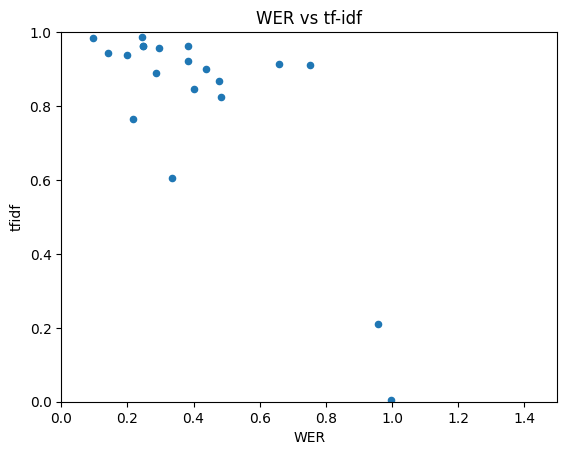

In [ ]:
df_pop = pd.read_csv("/gdrive/MyDrive/APPSA_tf/df_pop.csv")
graficas_res(df_pop)

Media métricas:
 WER       0.624511
Tf_idf    0.612931
CER       0.624511
MER       0.554690
dtype: float64

___________________________________________________




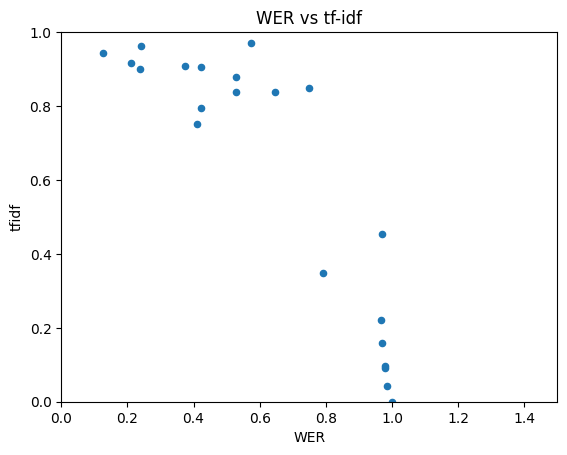

In [ ]:
df_rock = pd.read_csv("/gdrive/MyDrive/APPSA_tf/df_rock.csv")

graficas_res(df_rock)

Media métricas:
 WER       0.938196
Tf_idf    0.476862
CER       0.938196
MER       0.616120
dtype: float64

___________________________________________________




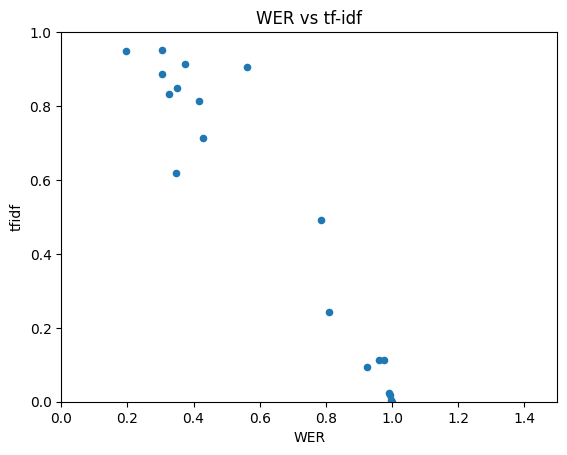

In [ ]:
graficas_res(df_metal)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def graficas_res(dfpop, dfrock, dfmetal):
  ax = dfpop.plot(x = "WER", y = "Tf_idf", kind = "scatter",c = "r", label = "pop", title = "WER vs tf-idf", xlabel = "WER", ylabel = "tfidf", xlim = (0,1.5), ylim = (0,1))

  dfrock.plot(x = "WER", y = "Tf_idf", kind = "scatter",c = "b",label = "rock", title = "WER vs tf-idf",ax = ax, xlabel = "WER", ylabel = "tfidf", xlim = (0,1.5), ylim = (0,1))

  dfmetal.plot(x = "WER", y = "Tf_idf", kind = "scatter",c = "g",label = "metal",  title = "WER vs tf-idf",ax = ax, xlabel = "WER", ylabel = "tfidf", xlim = (0,1.5), ylim = (0,1))
  plt.plot()

  print(f"Media métricas pop:\n", dfpop[["WER", "Tf_idf"]].mean() )
  print("\n___________________________________________________\n\n")

  print(f"Media métricas rock:\n", dfrock[["WER", "Tf_idf"]].mean() )
  print("\n___________________________________________________\n\n")

  print(f"Media métricas metal:\n", dfmetal[["WER", "Tf_idf"]].mean() )
  print("\n___________________________________________________\n\n")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Media métricas pop:
 WER       0.411853
Tf_idf    0.817634
dtype: float64

___________________________________________________


Media métricas rock:
 WER       0.624511
Tf_idf    0.612931
dtype: float64

___________________________________________________


Media métricas metal:
 WER       0.634191
Tf_idf    0.501960
dtype: float64

___________________________________________________




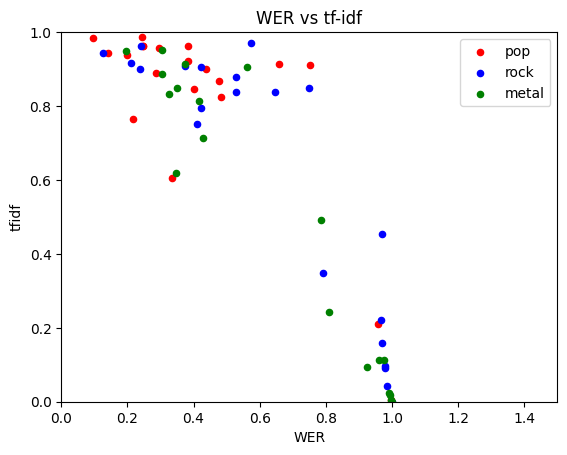

In [ ]:
df_pop= pd.read_csv("/gdrive/MyDrive/APPSA_tf/df_pop.csv")
df_rock = pd.read_csv("/gdrive/MyDrive/APPSA_tf/df_rock.csv")
df_metal = pd.read_csv("/gdrive/MyDrive/APPSA_tf/df_metal.csv")
df_metal = df_metal[df_metal["WER"] < 4]

graficas_res(df_pop, df_rock, df_metal)